In [1]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torchvision import transforms
cuda = torch.cuda.is_available()
from typing import List
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import cv2
import io
import glob
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: List[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)

In [4]:
class ARCNN(nn.Module):
    def __init__(self):
        super(ARCNN, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU(),
            nn.Conv2d(64, 32, kernel_size=7, padding=3),
            nn.PReLU(),
            nn.Conv2d(32, 32, kernel_size=1),
            nn.PReLU()
        )
        self.ASPP = ASPP(32, [1,4,8,16,24],16)
        self.last = nn.Conv2d(16, 3, kernel_size=5, padding=2)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)

    def forward(self, x):
        residual = x
        x = self.base(x)
        x = self.ASPP(x)
        x = self.last(x)
        x += residual
        return x

In [5]:
class ImageDataset(Dataset):

    def __init__(self, path, quality, rangeLen = None):
        self.image_files = sorted(glob.glob(path + '/*'))
        if(rangeLen != None):
            self.image_files = self.image_files[:rangeLen]
        self.quality = quality
        self.range = range
        self.images = []
        for i in tqdm(range(len(self.image_files))):
            self.images.append((Image.open(self.image_files[i]).convert("RGB")))


    def __getitem__(self, index):
        label = self.images[index]
        #noise addition
        buffer = io.BytesIO()
        label.save(buffer, format='jpeg', quality=self.quality)
        input = Image.open(buffer)

        input = np.array(input).astype(np.float32)
        label = np.array(label).astype(np.float32)
        input = np.transpose(input, axes=[2, 0, 1])
        label = np.transpose(label, axes=[2, 0, 1])

        # normalization
        input /= 255.0
        label /= 255.0

        return input, label

    def __len__(self):
        return len(self.images)

In [25]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval, save_path, totalLoss,save_every = 1, start_epoch=0):
    
    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, device, log_interval)
        totalLoss.append(train_loss)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)


        val_loss = test_epoch(val_loader, model, loss_fn, device)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)

        print(message)
        if(epoch%save_every == 0):
            print("Saving Model")
            save_checkpoint({
                        'epoch': epoch,
                        'state_dict': model.state_dict(),
                        'optimizer' : optimizer.state_dict(),
                }, epoch = epoch, path = save_path)




def train_epoch(train_loader, model, loss_fn, optimizer, device, log_interval):

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (jpgImg, rawImg) in enumerate(train_loader):

        if device != None:
            jpgImg = jpgImg.to(device)
            rawImg = rawImg.to(device)

        pred = model(jpgImg)
        loss = loss_fn(pred, rawImg)

        losses.append(loss.item())
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(jpgImg), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss


def test_epoch(val_loader, model, loss_fn, device):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_idx, (jpgImg, rawImg) in enumerate(val_loader):
            
            if(device != None):
                jpgImg = jpgImg.to(device)
                rawImg = rawImg.to(device)
            pred = model(jpgImg)
            loss = loss_fn(pred, rawImg)
            val_loss += loss.item()
    return val_loss


def save_checkpoint(state, epoch, path, filename='checkpoint.pth.tar'):
    filename = 'checkpoint' + str(epoch) + '.pth.tar'
    model_out_path = os.path.join(path, filename)
    torch.save(state, model_out_path)

In [23]:
batch_size = 2
lr = 5e-2
threads = 2
seed = 123
torch.manual_seed(seed)
path = '/content/drive/MyDrive/ImageCompression/'
save_path = path + 'modelHistory/'
#cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ARCNN()
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam([
        {'params': model.base.parameters()},
        {'params': model.last.parameters(), 'lr': lr * 0.1},
    ], lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.2, last_epoch=-1)

n_epochs = 100
log_interval = 25

In [26]:
totalLoss = []

In [21]:
datasetTrain = ImageDataset(path + '/cropped', quality = 10, rangeLen = 350)
datasetTest = ImageDataset(path + '/testing', quality = 10)
dataloaderTrain = torch.utils.data.DataLoader(dataset=datasetTrain,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=threads,
                            pin_memory=True,
                            drop_last=True)#

dataloaderTest = torch.utils.data.DataLoader(dataset=datasetTest,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=threads,
                            pin_memory=True,
                            drop_last=True)#

100%|██████████| 12/12 [00:00<00:00, 30.78it/s]


In [28]:
fit(dataloaderTrain, dataloaderTest, model, loss_fn, optimizer, scheduler, n_epochs, device, log_interval, save_path=save_path, save_every=2, totalLoss= totalLoss)

Train: [0/350 (0%)]	Loss: 0.001317
Train: [50/350 (14%)]	Loss: 0.001586
Train: [100/350 (29%)]	Loss: 0.001415
Train: [150/350 (43%)]	Loss: 0.001688
Train: [200/350 (57%)]	Loss: 0.001465
Train: [250/350 (71%)]	Loss: 0.001658
Train: [300/350 (86%)]	Loss: 0.001749
Epoch: 1/100. Train set: Average loss: 0.0016
Epoch: 1/100. Validation set: Average loss: 0.0018
Saving Model
Train: [0/350 (0%)]	Loss: 0.000870
Train: [50/350 (14%)]	Loss: 0.001510
Train: [100/350 (29%)]	Loss: 0.001830
Train: [150/350 (43%)]	Loss: 0.001663
Train: [200/350 (57%)]	Loss: 0.001557
Train: [250/350 (71%)]	Loss: 0.001604
Train: [300/350 (86%)]	Loss: 0.001538
Epoch: 2/100. Train set: Average loss: 0.0016
Epoch: 2/100. Validation set: Average loss: 0.0016
Train: [0/350 (0%)]	Loss: 0.002460
Train: [50/350 (14%)]	Loss: 0.001976
Train: [100/350 (29%)]	Loss: 0.001983
Train: [150/350 (43%)]	Loss: 0.002608
Train: [200/350 (57%)]	Loss: 0.003185
Train: [250/350 (71%)]	Loss: 0.002669
Train: [300/350 (86%)]	Loss: 0.002532
Epoch: 

KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

In [30]:
dataloaderTest = torch.utils.data.DataLoader(dataset=datasetTest,
                            batch_size=1,
                            shuffle=False,
                            num_workers=threads,
                            pin_memory=True,
                            drop_last=True)#



In [36]:
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

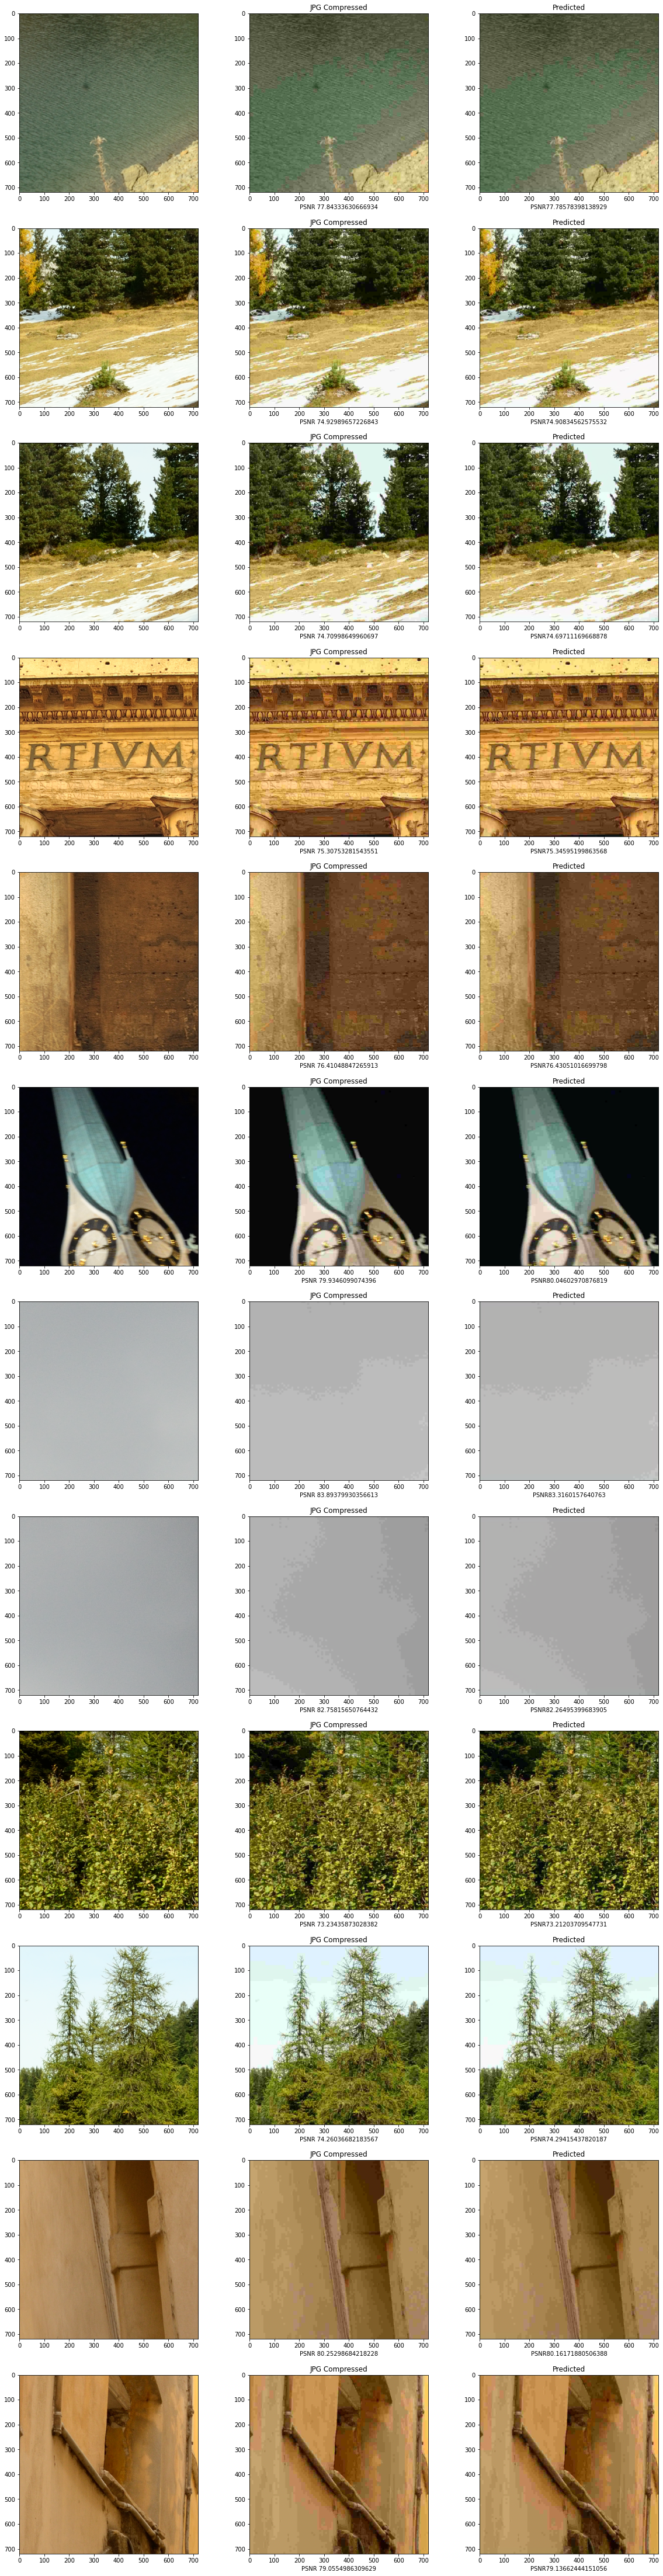

In [40]:
i = 1
fig = plt.figure(figsize=(20, 80))
model.eval()
for (jpgImg, rawImg) in dataloaderTest:
     jpgImg = jpgImg.to(device)
     pred = model(jpgImg)
     pred = pred.cpu().detach().numpy()
     jpgImg = jpgImg.cpu().detach().numpy()
     rawImg = np.transpose(rawImg[0], axes=[1, 2, 0])
     jpgImg = np.transpose(jpgImg[0], axes=[1, 2, 0])
     pred = np.transpose(pred[0], axes=[1, 2, 0])
     fig.add_subplot(12, 3, i)
     plt.imshow(rawImg)
     fig.add_subplot(12, 3, i+1)
     plt.imshow(jpgImg)
     psnr = cv2.PSNR(np.array(rawImg), np.array(jpgImg))
     plt.title("JPG Compressed")
     plt.xlabel("PSNR " + str(psnr))
     fig.add_subplot(12, 3, i+2)
     plt.imshow(pred)
     psnr = cv2.PSNR(np.array(rawImg), np.array(pred))
     plt.title("Predicted")
     plt.xlabel("PSNR" + str(psnr))
     i = i+3


plt.show()